In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import data for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.optimizers import Adam
import random
from tqdm.notebook import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


# Function to Load and preprocess the images loaded into the notebook.
This code loads all images and masks into the noebook while retaining the directory name as label (according to the data). While loading the data, the images and masks are also preprocessed as below:
1. Convert to GrayScale
2. Resize image to (128 * 128) pixel size for ease of processing

In [2]:
def load_data(data_dir):
    classes = os.listdir(data_dir)
    images = []
    masks = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_subdir = os.path.join(class_dir, 'images')
            mask_subdir = os.path.join(class_dir, 'masks')

            for filename in os.listdir(image_subdir):
                if filename.endswith(".png"):
                    # Load image
                    image_path = os.path.join(image_subdir, filename)
                    if not os.path.exists(image_path):
                        print(f"Image not found: {image_path}")
                        continue

                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, (128,128))
                    images.append(image)

                    # Load mask
                    mask_filename = filename
                    mask_path = os.path.join(mask_subdir, mask_filename)
                    if not os.path.exists(mask_path):
                        print(f"Mask not found: {mask_path}")
                        continue

                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (128,128))
                    masks.append(mask)

                    # Assign label based on class name
                    labels.append(class_name)

    return np.array(images), np.array(masks), np.array(labels)

data_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
images, masks, labels = load_data(data_dir)


In [3]:
print(len(images))
print(len(masks))
print(len(labels))

21165
21165
21165


# Function to plot the images from Loaded Dataset
This function selects random subset of images from the dataset and displays the images along with their respective mask. The function also displays the mask when applied on image.

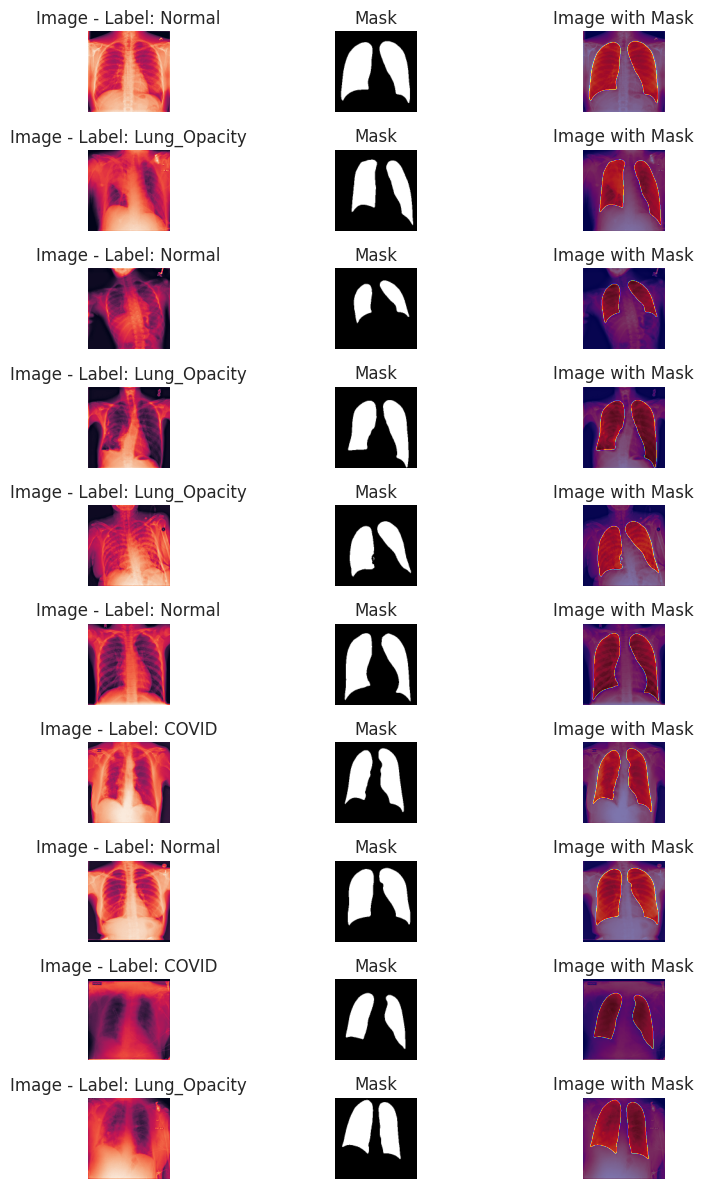

In [4]:
def plot_images_with_masks(images, masks, labels, num_images=10):
    # Select a random subset of indices
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 6 * num_images // 5))

    for i, idx in enumerate(indices, start=1):
        #Images
        plt.subplot(num_images, 6, 6 * i - 2)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Image - Label: {labels[idx]}")

        #Masks
        plt.subplot(num_images, 6, 6 * i - 1)
        plt.imshow(masks[idx], cmap='gray')
        plt.axis('off')
        plt.title("Mask")

        # Overlay mask on the image
        plt.subplot(num_images, 6, 6 * i)
        plt.imshow(images[idx])
        plt.imshow(masks[idx], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title("Image with Mask")

    plt.tight_layout()
    plt.show()

plot_images_with_masks(images, masks, labels, num_images=10)


# Splitting the images and masks into Training and Testing sets with a 80/20 ratio

In [5]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images = np.array(train_images).reshape(len(train_images),128,128)
test_images = np.array(test_images).reshape(len(test_images),128,128)
print(train_images.shape)
print(test_images.shape)
print(train_masks.shape)
print(test_masks.shape)

(16932, 128, 128)
(4233, 128, 128)
(16932, 128, 128)
(4233, 128, 128)


# U2-Net Architecture
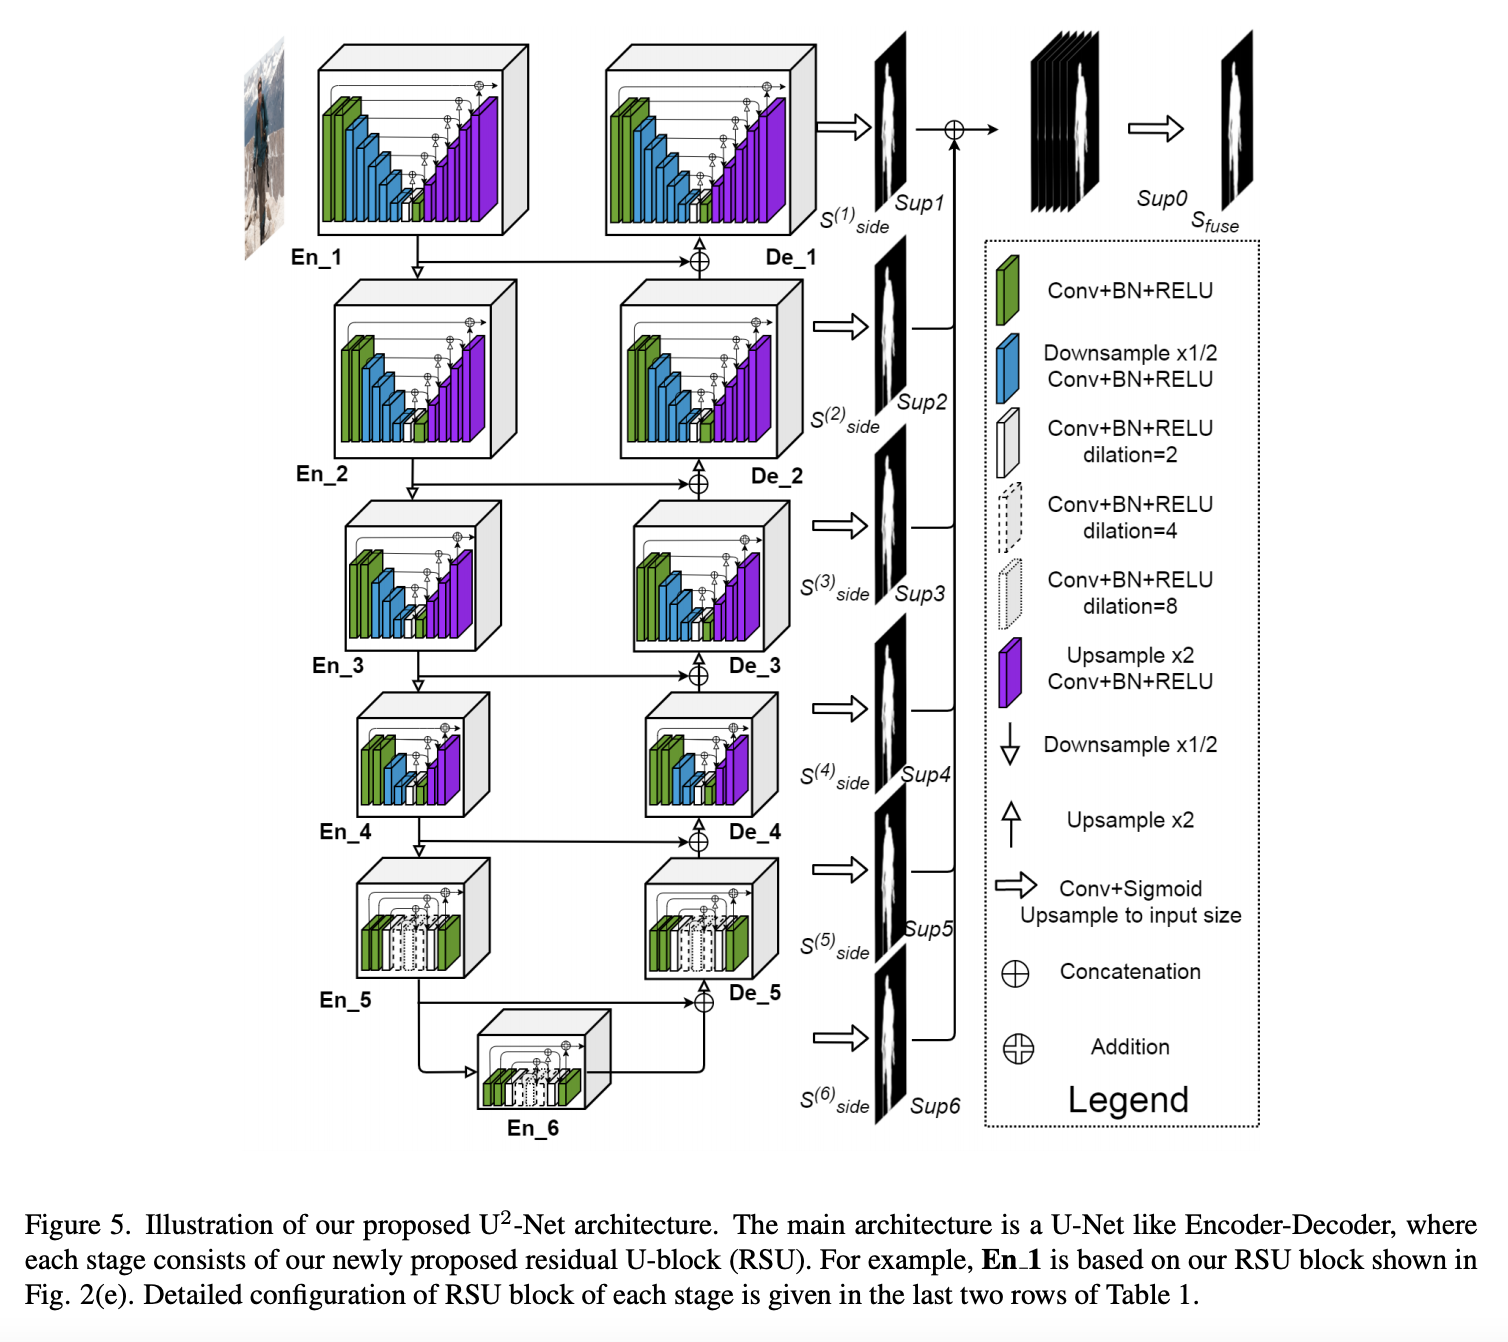

In [6]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)
        
    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x

def RSU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    input_shape_with_channels = input_shape + (1,)
    model = u2net(input_shape_with_channels, out_ch, M_ch, num_classes=num_classes)
    return model

u2net_model = build_u2net_lite((128,128))
#u2net_model.summary()

In [7]:
opt = Adam(learning_rate=1e-3)
u2net_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('ChestSegmentor.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

# Training the U2Net model on our images and masks

In [9]:
hsitory = u2net_model.fit(train_images, train_masks, validation_split = 0.2, batch_size = 16, epochs = 100, callbacks=get_callbacks())

Epoch 1/100
847/847 [==============================] - ETA: 0s - loss: -918.5223 - accuracy: 0.3279
Epoch 1: val_loss improved from inf to -925.31531, saving model to ChestSegmentor.hdf5
847/847 [==============================] - 229s 172ms/step - loss: -918.5223 - accuracy: 0.3279 - val_loss: -925.3153 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 2/100
847/847 [==============================] - ETA: 0s - loss: -923.4390 - accuracy: 0.5322
Epoch 2: val_loss did not improve from -925.31531
847/847 [==============================] - 138s 163ms/step - loss: -923.4390 - accuracy: 0.5322 - val_loss: -921.3240 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 3/100
847/847 [==============================] - ETA: 0s - loss: -923.9284 - accuracy: 0.5687
Epoch 3: val_loss improved from -925.31531 to -925.47076, saving model to ChestSegmentor.hdf5
847/847 [==============================] - 139s 165ms/step - loss: -923.9284 - accuracy: 0.5687 - val_loss: -925.4708 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 4

The U2Net model takes some time to train as it is a Stacked Auto-Encoder and the size of data being passed is also large. But at the end, we get an accuracy of 72.15% on generation of masks from images and when tested on test set, we get similar accuracy of 72.08%. This is a good score, but with more computational resources and some changes to this architecture we can get a better accuracy on generating masks from images on this dataset.

# Saving model weights and using these weights to generate and display 10 random images, masks and masked images

133/133 [==============================] - 17s 86ms/step


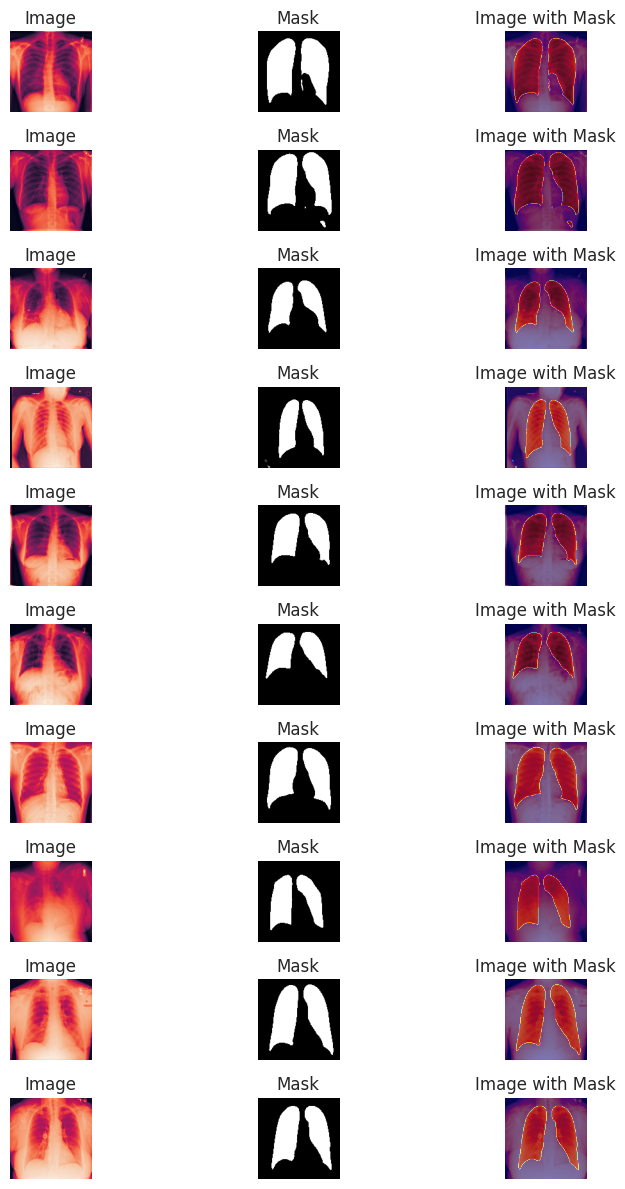

In [10]:
u2net_model.load_weights("ChestSegmentor.hdf5")
def generate_masks(model, test_images):
    masks = model.predict(test_images)
    return masks

def plot_testimages_with_masks(images, masks, num_images=10):
    # Select a random subset of indices
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize = (15, 6 * num_images // 5))

    for i, idx in enumerate(indices, start=1):
        #Images
        plt.subplot(num_images, 6, 6 * i - 2)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title("Image")

        #Masks
        plt.subplot(num_images, 6, 6 * i - 1)
        plt.imshow(masks[idx], cmap='gray')
        plt.axis('off')
        plt.title("Mask")

        # Overlay mask on the image
        plt.subplot(num_images, 6, 6 * i)
        plt.imshow(images[idx])
        plt.imshow(masks[idx], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title("Image with Mask")

    plt.tight_layout()
    plt.show()
    
generated_masks = generate_masks(u2net_model, test_images)
plot_testimages_with_masks(test_images, generated_masks, num_images=10)

# Label Encoding the data to feed into Classifier

In [11]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels, num_classes=4)
train_images, test_images, train_labels, test_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
train_images = np.array(train_images).reshape(len(train_images),128,128)
test_images = np.array(test_images).reshape(len(test_images),128,128)
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(16932, 128, 128)
(4233, 128, 128)
(16932, 4)
(4233, 4)


# Building a classification model on top of the U2Net Segmentor

In [12]:
def build_classification_model(base_model):
    
    u2net_base = Model(inputs=base_model.input, outputs=base_model.output)

    for layer in u2net_base.layers:
        layer.trainable = False

    flat_layer = Flatten()(u2net_base.output)
    dense_layer = Dense(256, activation='relu')(flat_layer)
    output_layer = Dense(4, activation='softmax')(dense_layer)

    classification_model = Model(inputs=base_model.input, outputs=output_layer)
    return classification_model

classification_model = build_classification_model(u2net_model)
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#classification_model.summary()

# Save the best model weights during training
checkpoint_filepath = 'classification_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [13]:
history = classification_model.fit(train_images, train_labels, validation_split = 0.2, batch_size = 16, epochs = 50, callbacks=model_checkpoint_callback)

Epoch 1/50
847/847 [==============================] - 63s 65ms/step - loss: 1.0685 - accuracy: 0.5787 - val_loss: 0.9204 - val_accuracy: 0.6020
Epoch 2/50
847/847 [==============================] - 51s 61ms/step - loss: 0.8912 - accuracy: 0.6130 - val_loss: 0.9249 - val_accuracy: 0.5902
Epoch 3/50
847/847 [==============================] - 50s 59ms/step - loss: 0.8649 - accuracy: 0.6270 - val_loss: 0.9525 - val_accuracy: 0.5875
Epoch 4/50
847/847 [==============================] - 51s 60ms/step - loss: 0.8368 - accuracy: 0.6439 - val_loss: 0.9128 - val_accuracy: 0.6038
Epoch 5/50
847/847 [==============================] - 51s 60ms/step - loss: 0.8179 - accuracy: 0.6529 - val_loss: 0.9476 - val_accuracy: 0.6141
Epoch 6/50
847/847 [==============================] - 51s 61ms/step - loss: 0.8052 - accuracy: 0.6614 - val_loss: 0.8970 - val_accuracy: 0.6174
Epoch 7/50
847/847 [==============================] - 52s 61ms/step - loss: 0.7887 - accuracy: 0.6635 - val_loss: 0.8601 - val_accuracy:

In [14]:
evaluation_result = classification_model.evaluate(test_images, test_labels)

133/133 [==============================] - 12s 89ms/step - loss: 1.5124 - accuracy: 0.6249


In [15]:
accuracy = evaluation_result[1]
print(f'Model Accuracy on Test Data: {accuracy}')

Model Accuracy on Test Data: 0.6248523592948914


From the above results, we can see that the accuracy of the classifier in top of the segmentation model is only 63.59%. This is still too low and we can finetune the classification model adding a few layers which can help in increasing the accuracy. This might also be due to the low segementation accurcay. Since the masks being generated are only 70% accurate, the areas being identified by the classification model might not be too precise resulting in this low accuracy.